In [16]:
import numpy as np
import pylab as pl
from scipy import optimize 
import os
from scipy.ndimage.interpolation import rotate

# constants
G = 6.67408e-8 # cm3 g-1 s-2
Msun = 1.989e33 # g
au = 1.496e13 # cm

In [17]:
# AS209
mstar = 0.9*Msun
i = np.radians(180+34.88677) # south is closer
#i = np.radians(360-34.88677) # north is closer
phi = np.radians(15.)
Rmax = 300. # au
vmax = 5
vsou = 4.75
vels_lev = np.array([3,3.7,4.4,5.1,5.8,6.5]) - vsou
print vels_lev
pa = 90-85.4526 # degrees

[-1.75 -1.05 -0.35  0.35  1.05  1.75]


In [18]:
# projected coordinates (should be xprime, yprime)
nx, ny = (100,100)
xp = np.linspace(-Rmax, Rmax, nx)
yp = np.linspace(-Rmax, Rmax, ny)
xxp, yyp = np.meshgrid(xp, yp)

In [19]:
###########################################################
# Thin disk -> flat 

# deprojected coords y = yp/cosi
xx = xxp
yy = yyp/np.cos(i)
rr = np.sqrt(xx**2+yy**2) # au
rr_cm = rr*au # cm
theta = np.arctan2(yy,xx)

# projected line of sight velocity at x',y'
vel_thin = np.sqrt(G*mstar/rr_cm)*np.sin(i)*np.cos(theta) # cm/s
vel_thin /= 1e5 # km/s

# rotate
vel_thin = rotate(vel_thin,pa)

In [20]:
###########################################################
# Flared disk -> cone

# intersection of line with cone:
# yp = (y - t*sin(i))*cosi
# zp = t*cos(i)

# where t are the solution of a line intersecting a cone
# t**2 * (np.cos(2*i) + np.cos(2*phi)) - 2*np.sin(phi)**2 * (xxp**2 + yyp**2*np.sec(i)**2 + 2*t*yyp*np.tan(i)) = 0
# The positive and negative roots of this equation correspond tothe near and far halves
# of the double cone, respectively

# solve for t
def f(t,ixp,iyp):
    return (np.cos(2*i) + np.cos(2*phi))*t**2 - (2*np.sin(phi)**2*2*iyp*np.tan(i))*t - (2*np.sin(phi)**2*(ixp**2 + iyp**2*seci**2 ))

seci = 1/np.cos(i)
tt_near = np.zeros(yyp.shape) # near side of the disk
tt_far = np.zeros(yyp.shape) # far side of the disk

for ix in range(nx):
    for iy in range(ny):
        sol = optimize.root(f, [0.], args=(xxp[ix,iy],yyp[ix,iy]), method='lm')
        if np.degrees(i)<180:
            tt_near[ix,iy] = np.abs(sol.x) # au
            tt_far[ix,iy] = -np.abs(sol.x)
        else:
            tt_far[ix,iy] = np.abs(sol.x) # au
            tt_near[ix,iy] = -np.abs(sol.x)
            
xx = xxp
yy_near = yyp/np.cos(i) + tt_near*np.sin(i)
zz_near = tt_near*np.cos(i)
rr_near = np.sqrt(xx**2+yy_near**2+zz_near**2) # au
#rr_pos = np.sqrt(xx**2+yy_pos**2) # au
rr_near_cm = rr_near*au # cm
theta_near = np.arctan2(yy_near,xx)

yy_far = yyp/np.cos(i) + tt_far*np.sin(i)
zz_far = tt_far*np.cos(i)
rr_far = np.sqrt(xx**2+yy_far**2+zz_far**2) # au
#rr_neg = np.sqrt(xx**2+yy_neg**2) # au
rr_far_cm = rr_far*au # cm
theta_far = np.arctan2(yy_far,xx)

vel_near = np.sqrt(G*mstar/rr_near_cm)*np.sin(i)*np.cos(theta_near)/1e5 # km/s
vel_far = np.sqrt(G*mstar/rr_far_cm)*np.sin(i)*np.cos(theta_far)/1e5 # km/s

# rotate
vel_near = rotate(vel_near,pa)
vel_far = rotate(vel_far,pa)            

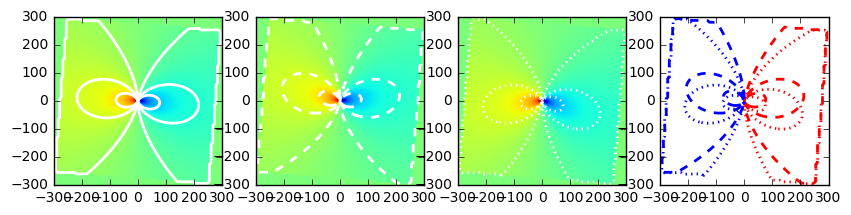

In [21]:
# Plot
fig, (ax1,ax2,ax3,ax4) = pl.subplots(1,4,figsize=(10,10))
ext=[-Rmax,Rmax,-Rmax,Rmax]

im1 = ax1.imshow(vel_thin,extent=ext,origin='lower',vmin=-vmax,vmax=vmax)
ax1.contour(vel_thin,vels_lev,extent=ext,origin='lower',colors='white',linestyles='solid',linewidths=2)

im2 = ax2.imshow(vel_near,extent=ext,origin='lower',vmin=-vmax,vmax=vmax)
ax2.contour(vel_near,vels_lev,extent=ext,origin='lower',colors='white',linestyles='dashed',linewidths=2)

im3 = ax3.imshow(vel_far,extent=ext,origin='lower',vmin=-vmax,vmax=vmax)
ax3.contour(vel_far,vels_lev,extent=ext,origin='lower',colors='white',linestyles='dotted',linewidths=2)

cols = ['red','red','red','blue','blue','blue']
im4 = ax4.imshow(vel_thin*0,extent=ext,origin='lower',cmap='gray_r')
#ax4.contour(vel_thin,[-1.05,1.05],extent=ext,origin='lower',colors=cols,linestyles='solid',linewidths=2)
#ax4.contour(vel_near,[-1.05,1.05],extent=ext,origin='lower',colors=cols,linestyles='dashed',linewidths=2)
#ax4.contour(vel_far,[-1.05,1.05],extent=ext,origin='lower',colors=cols,linestyles='dotted',linewidths=2)

ax4.contour(vel_near,vels_lev,extent=ext,origin='lower',colors=cols,linestyles='dashed',linewidths=2)
ax4.contour(vel_far,vels_lev,extent=ext,origin='lower',colors=cols,linestyles='dotted',linewidths=2)

for ax in ax1,ax2,ax3,ax4:
    ax.set_xlim([-Rmax,Rmax])
    ax.set_ylim([-Rmax,Rmax])

    
pl.show()